In [188]:
## New Algorithm
import numpy as np
import random
import math
import scipy.special as sp
from scipy.stats import spearmanr
from scipy.stats import norm, multivariate_normal

## Sampling
def CDF(p):    
    dist = [0 for i in range(len(p))]
    for i in range(len(p)):
        for j in range(0, i+1):
            dist[i] += p[j]

    dist = np.array(dist)
    return dist

def binary_search(cdf, target, left, right):
    while left < right:
        mid = (left + right) // 2
        if cdf[mid] < target:
            left = mid + 1
        else:
            right = mid
    return left

def inverse_transform_sampling(cdf, n_samples, left, right):
    u = np.random.rand(n_samples)
    samples = [binary_search(cdf, uu, left, right) for uu in u]
    return samples

In [189]:
## Zone 검증은 user 수를 늘린 상태로 sampling 하여 진행한다.

In [190]:
num_user  = 10000
num_genre = 10
Corr_coeff_rank = np.array([[1, 0.6096, 0.1456],[0.6096, 1, -0.3845],[0.1456, -0.3845, 1]])
rho = 2 * np.sin(np.pi * Corr_coeff_rank / 6)
mvn = multivariate_normal(mean=np.zeros(3), cov=rho)
samples = mvn.rvs(size=num_genre)
u = norm.cdf(samples)

In [191]:
dict1 = []
dict2 = []
dict3 = []
dict = [dict1, dict2, dict3]
for i in range(3):
    for j in range(len(u[:,i])):
        dict[i].append([u[:,i][j],j])
        
for i in dict:
    i.sort(key = lambda x: (x[0],x[1]))

In [192]:
Gamma_a_model_copula = [0 for _ in range(num_genre)]
Gamma_b_model_copula = [0 for _ in range(num_genre)]
ranking_model_copula = [0 for _ in range(num_genre)]

In [193]:
## Weibull
bw = 5.18285 # scailing
aw = 2.43009 # shaping 논문 반대로 써져있음;

## Gamma
ag =   7.58648
bg = 0.0724974
temp1 = np.sort(np.random.weibull(aw, num_genre) * bw)
temp2 = np.sort(np.random.gamma(ag,bg,num_genre))
temp3 = [i for i in range(num_genre)]
for i in range(len(dict[0])):  
    i1 = dict[0][i][1]
    i2 = dict[1][i][1]
    i3 = dict[2][i][1]

    Gamma_a_model_copula[i1] = temp1[i]
    Gamma_b_model_copula[i2] = temp2[i]
    ranking_model_copula[i3] = temp3[i]

In [194]:
rank_dict = []
for i in range(len(ranking_model_copula)):
    rank_dict.append([ranking_model_copula[i],i])

In [195]:
rank_dict.sort(key = lambda x: (x[0],x[1]))
rank_dict = np.array(rank_dict)
IX = rank_dict[:,1]

In [196]:
Gamma_a_copula_in_order = [0 for _ in range(num_genre)]
Gamma_b_copula_in_order = [0 for _ in range(num_genre)]

for i in range(num_genre):
    Gamma_a_copula_in_order[i] = Gamma_a_model_copula[IX[i]]
    Gamma_b_copula_in_order[i] = Gamma_b_model_copula[IX[i]]

In [197]:
Genre_ranking_prob = []
for i in range(num_genre):
    gamma_para_a = Gamma_a_copula_in_order[i]
    gamma_para_b = Gamma_b_copula_in_order[i]
    Pr_Acc = [0 for _ in range(num_genre)]
    for j in range(num_genre):
        Pr_Acc[j] = (gamma_para_b**gamma_para_a)*((j+1)**(gamma_para_a-1))*math.exp(-gamma_para_b*(j+1))/sp.gamma(gamma_para_a);
    Genre_ranking_prob.append((Pr_Acc/sum(Pr_Acc)))

In [198]:
user = []
u = 0
while(u<num_user):
    s = 0
    I = [0 for _ in range(num_genre)]
    indicat_showup = [0 for _ in range(num_genre)]
    while(s<num_genre):
        rand_order_g = np.arange(1, num_genre + 1)
        perm = np.random.permutation(np.arange(2, num_genre + 1))
        rand_order_g[1:] = perm
        for i in range(num_genre):
            idx = rand_order_g[i]
            if(indicat_showup[idx-1]<1):
                p = Genre_ranking_prob[idx-1]
                p = CDF(p)
                temp_rank = inverse_transform_sampling(p, 1, 1, num_genre)[0]
                if(s<num_genre):
                    indicat_showup[idx-1] = 1
                    I[idx-1] = temp_rank
                    s = s + 1

    I_result = np.array(I)*np.array(indicat_showup)
    IX = np.argsort(I_result)
    for i in range(len(IX)):
        IX[i]+=1
    Sample_results = IX
    user.append(Sample_results)
    u+=1

In [199]:
stat = [[0 for _ in range(num_genre)] for _ in range(num_genre)] 
for u in user:
    for rank, i in enumerate(u):
        stat[rank][i-1]+=1     

In [200]:
weighted_stat = [0 for _ in range(num_genre)]
for idx, s in enumerate(stat):
    for g in range(num_genre):
        weighted_stat[g]+=s[g]*(num_genre-idx)/num_genre

weighted_rank = np.argsort(weighted_stat)
weighted_rank = weighted_rank[::-1]

In [201]:
print(weighted_stat)

[5754.0, 4601.0, 8382.100000000002, 3635.5, 6528.3, 3616.5, 8903.800000000001, 5286.799999999999, 3550.3, 4741.700000000001]


In [202]:
genre_desire = []
idx = 0
chk = []
for i in Genre_ranking_prob:
    temp = np.array(i)
    #print(temp)
    #print(temp.argmax(), temp[temp.argmax()])
    temp2 = [temp.argmax(), temp[temp.argmax()], idx]
    chk.append(temp2)
    genre_desire.append(temp.argmax())
    idx+=1
genre_desire = np.argsort(genre_desire)

In [203]:
chk.sort(key = lambda x: (x[0], x[2]))

In [204]:
chk

[[0, 0.42921640642425835, 6],
 [1, 0.1913151228175339, 2],
 [4, 0.14132675367759898, 4],
 [6, 0.15358114339842616, 0],
 [6, 0.14941001305627397, 7],
 [7, 0.14455588226340432, 9],
 [9, 0.20623346553383246, 1],
 [9, 0.28577897817143383, 3],
 [9, 0.25306312384340574, 5],
 [9, 0.23017058086344683, 8]]

In [205]:
print("sample:",weighted_rank,sep="")
print("desire:",genre_desire,sep="")

sample:[6 2 4 0 7 9 1 3 5 8]
desire:[6 2 4 0 7 9 1 3 5 8]


In [206]:
g = [[ 0 for _ in range(num_genre)]for _ in range(num_genre)]
for r, i in enumerate(stat):
    for gi, i in enumerate(i):
        g[gi][r] += i

for i in range(len(g)):
    s = 0
    for j in range(len(g[i])):
        s+=g[i][j]
    for j in range(len(g[i])):
        g[i][j]/=s

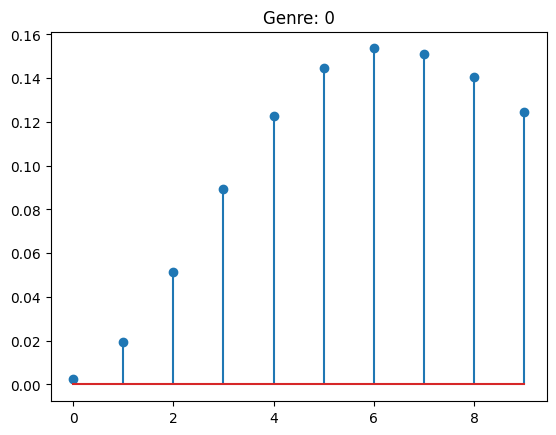

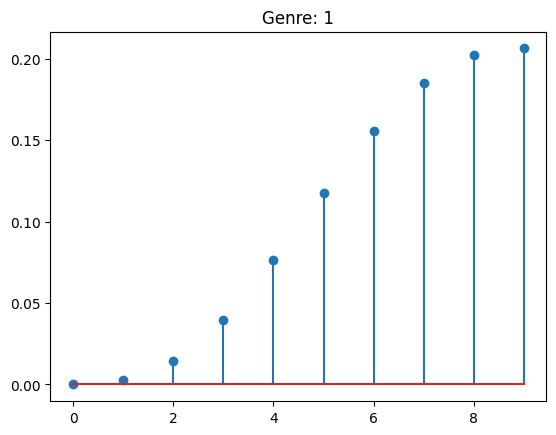

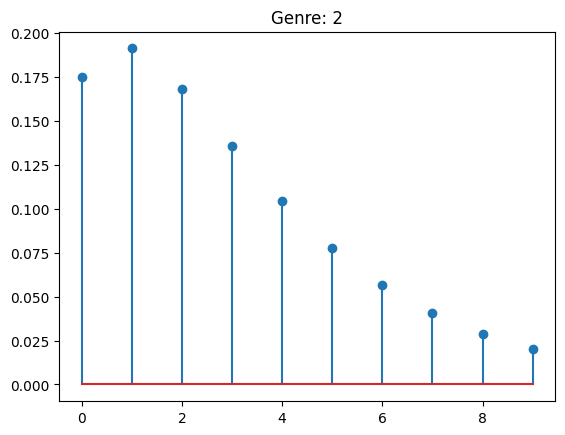

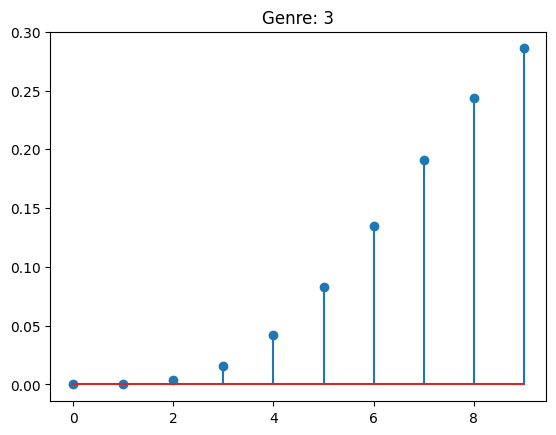

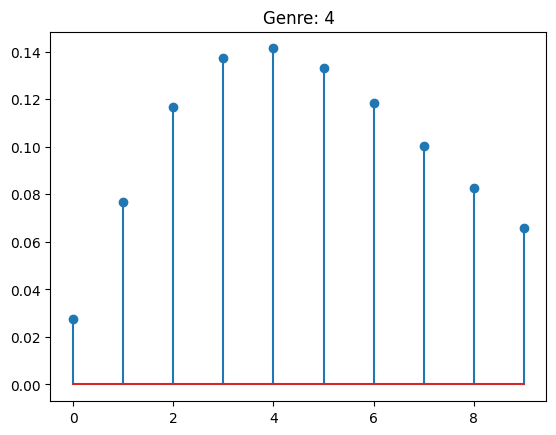

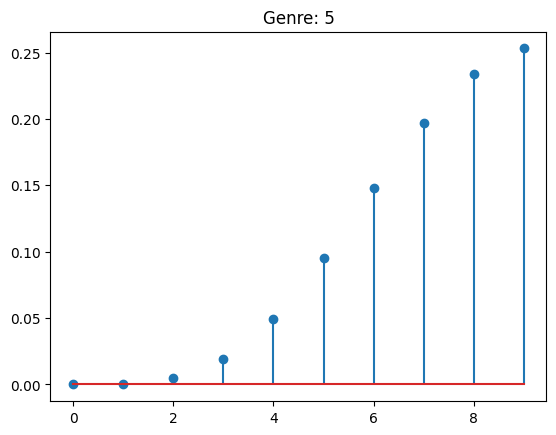

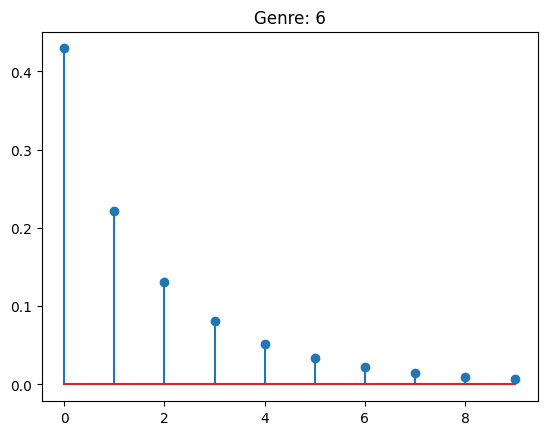

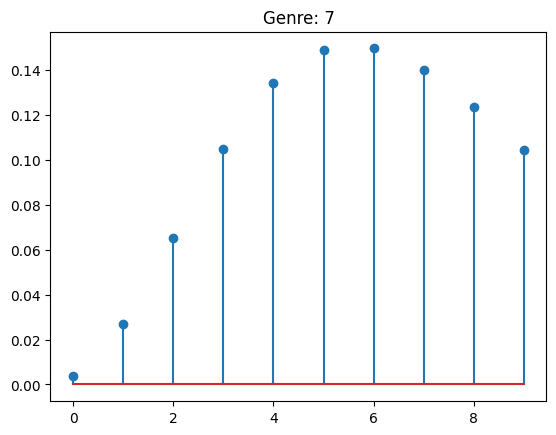

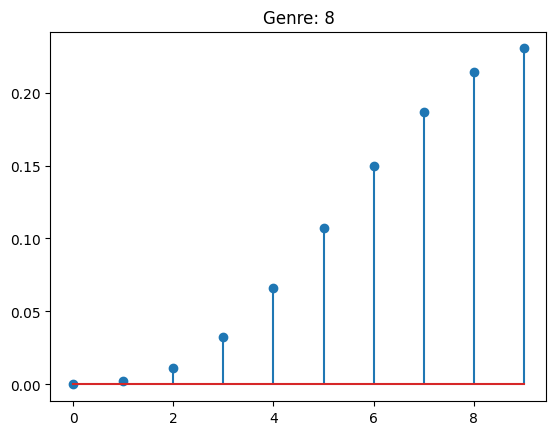

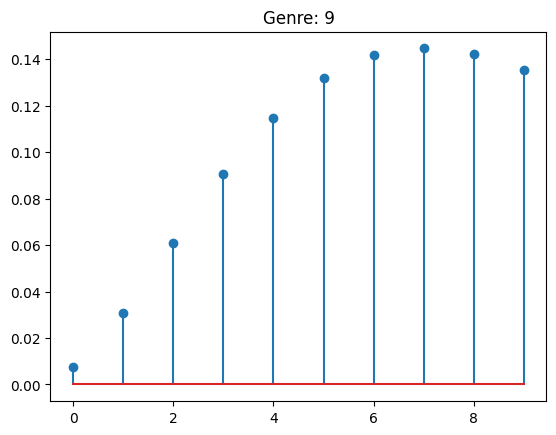

In [207]:
import matplotlib.pyplot as plt
cnt = 0
for i in Genre_ranking_prob:
    
    plt.stem([ii for ii in range(num_genre)], i)
    title = "Genre: "
    title+=str(cnt)
    cnt+=1
    plt.title(title)
    plt.show()

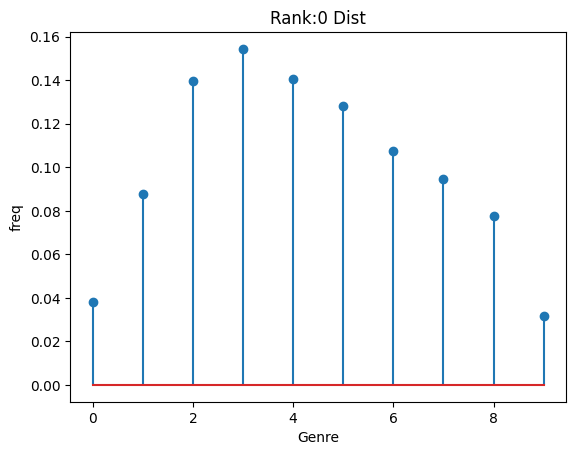

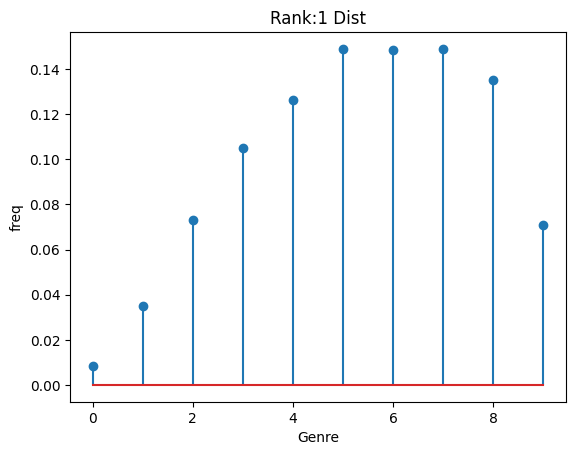

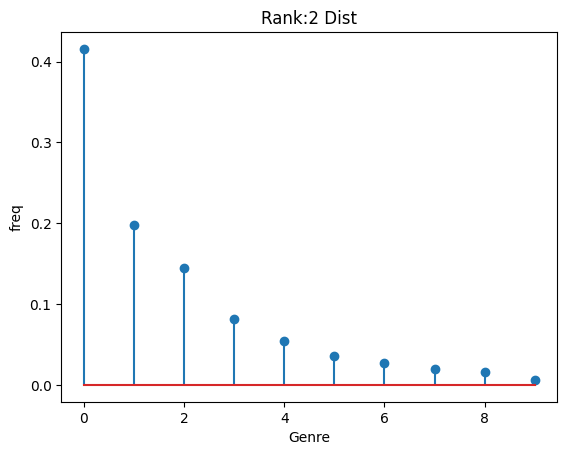

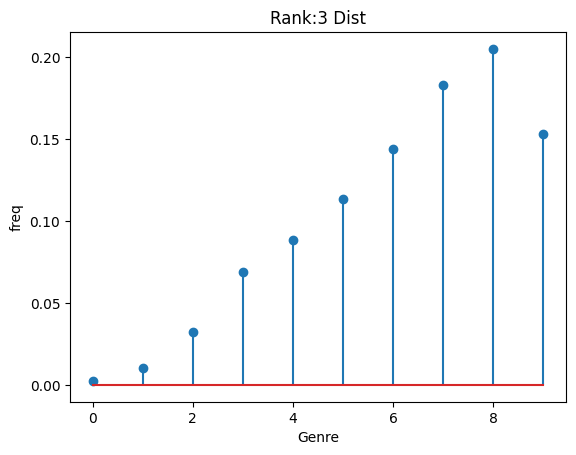

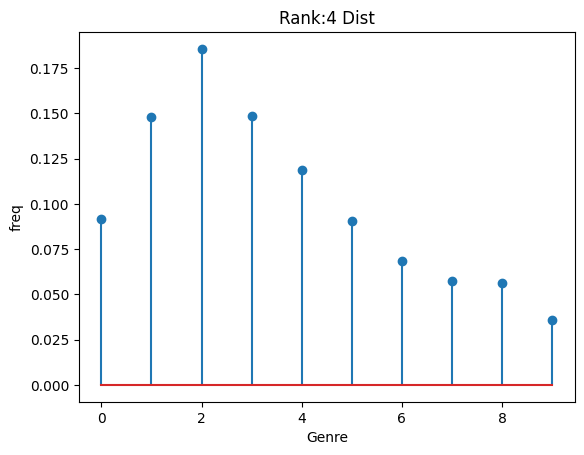

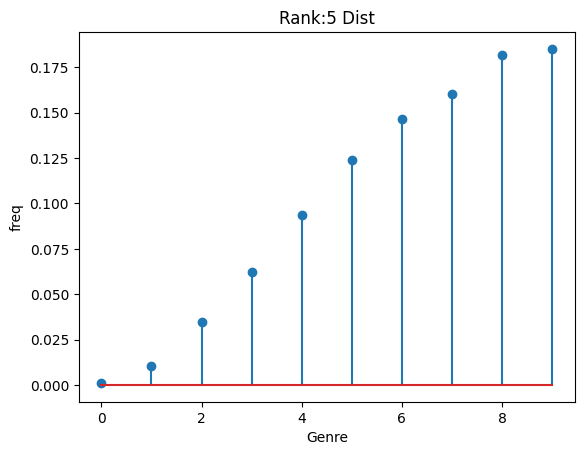

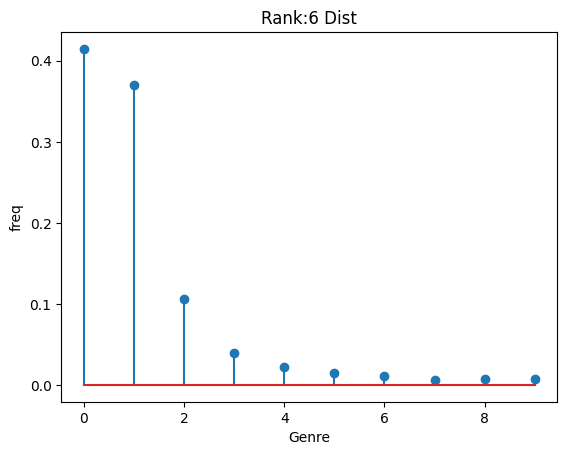

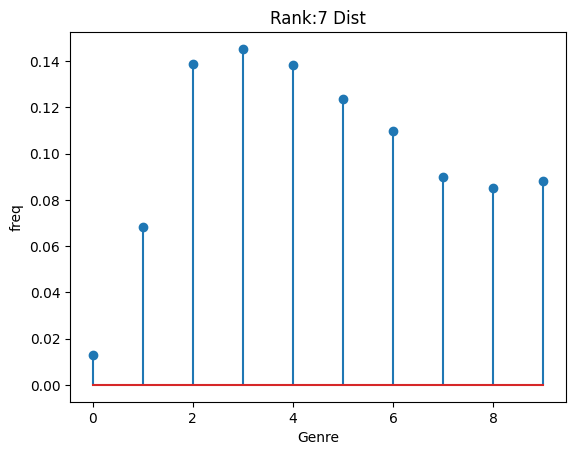

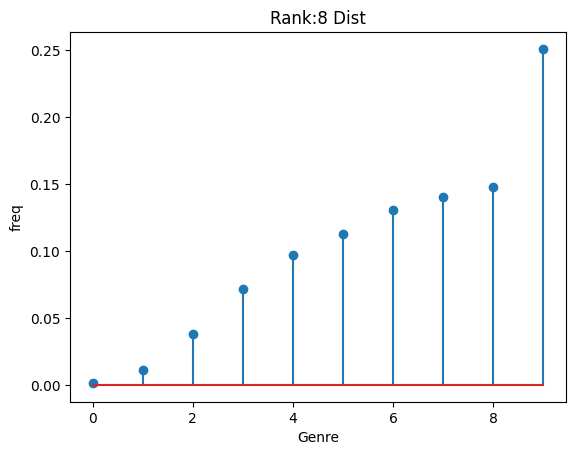

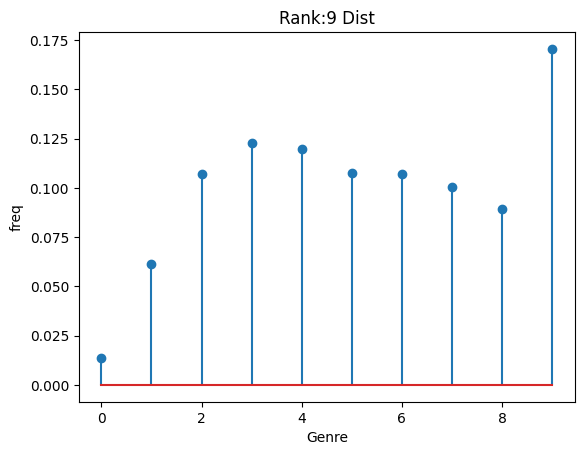

In [208]:
import matplotlib.pyplot as plt
for idx, s in enumerate(g):
    plt.stem([i for i in range(num_genre)], s)
    plt.title("Rank:"+str(idx)+" Dist")
    plt.xlabel("Genre")
    plt.ylabel("freq")
    plt.show()

In [209]:
import pickle
with open("mt_zone1.pkl", "wb") as f:
    pickle.dump(user, f)

In [210]:
with open("gamma_a_zone1.pkl", "wb") as f:
    pickle.dump(gamma_para_a, f)

In [211]:
with open("gamma_b_zone1.pkl", "wb") as f:
    pickle.dump(gamma_para_b, f)